In [105]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute, transpile
from qiskit.circuit.library import QFT
import qiskit.providers.fake_provider as fp

In [106]:
eval_qubit = 3
total_qubit = eval_qubit+1  # eval + target qubit 1개

p = 0.34
theta_p = 2 * np.arcsin(np.sqrt(p))  # QAA의 A를 만들기 위한 Ry 각도
theta_for_q = 2 * theta_p  # Q의 각도

shots = 10000

In [107]:
qreg_q = QuantumRegister(total_qubit, 'q')
creg_c = ClassicalRegister(total_qubit-1, 'c')  # 하나 없어도 되나?
circuit = QuantumCircuit(qreg_q, creg_c)

In [108]:
circuit.h(qreg_q[0:eval_qubit])
circuit.ry(theta_p, qreg_q[eval_qubit])
circuit.barrier()

for i in range(eval_qubit):
    circuit.cry(theta_for_q * (2**(eval_qubit-1-i)), qreg_q[i], qreg_q[eval_qubit])
    circuit.barrier()
    
circuit.append(QFT(eval_qubit, inverse=True, do_swaps=False), 
               qreg_q[0:eval_qubit])
circuit.barrier()

for i in range(eval_qubit):
    circuit.measure(qreg_q[i], creg_c[i])

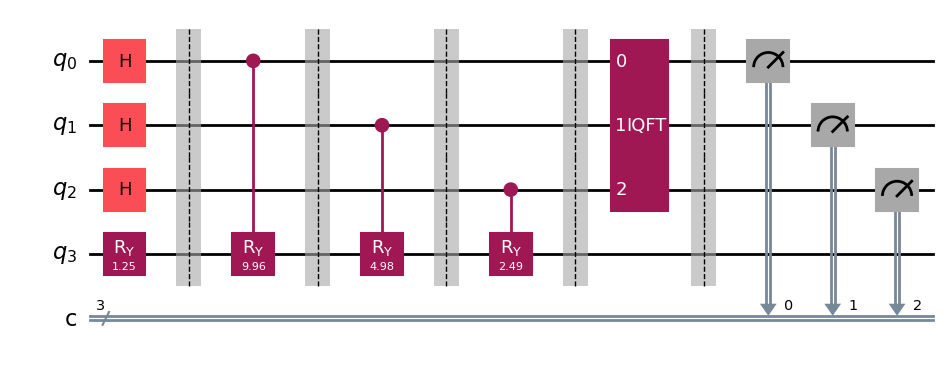

In [109]:
circuit.draw(output='mpl', style="iqp")

In [110]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, simulator, shots=shots).result()
counts = result.get_counts(circuit)

In [111]:
counts #반대 순서

{'101': 345,
 '100': 203,
 '110': 2814,
 '001': 1457,
 '111': 1500,
 '011': 333,
 '010': 2903,
 '000': 445}

Post Processing

In [112]:
counts = {key: value / shots for key, value in counts.items()}

In [113]:
p_tilde = [np.round(np.sin(i*np.pi/(2**eval_qubit))**2,3) for i in range(2**(eval_qubit-1)+1)]

In [114]:
p_tilde

[0.0, 0.146, 0.5, 0.854, 1.0]

In [115]:
probs = np.zeros(2**eval_qubit, dtype=float)
for state, value in counts.items():
    state_decimal = int(state, 2)
    probs[state_decimal] = value
    
freqs =[]
freqs.append(probs[0])
i = 1
while i < 2**eval_qubit/2:
    # print(f'These states correspond to the same bin: {i} and {2**m-i}')
    freqs.append(probs[i] + probs[2**eval_qubit-i])
    i += 1
freqs.append(probs[2**(eval_qubit-1)])

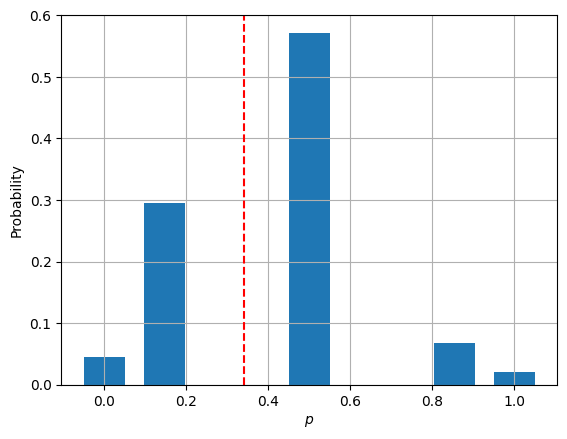

In [116]:
gridpoints = list(p_tilde)
probabilities = list(freqs)

plt.bar(gridpoints, probabilities, width=0.5 / len(probabilities))
plt.axvline(p, color="r", ls="--")
plt.ylabel("Probability")
plt.xlabel(r"$p$")
plt.grid()
plt.show()

In [117]:
backend = fp.FakeYorktown()

In [118]:
transpile(circuit.decompose(reps=8)).count_ops()['cx']

12

In [119]:
transpile(circuit.decompose(reps=8), backend=backend).count_ops()['cx']

15

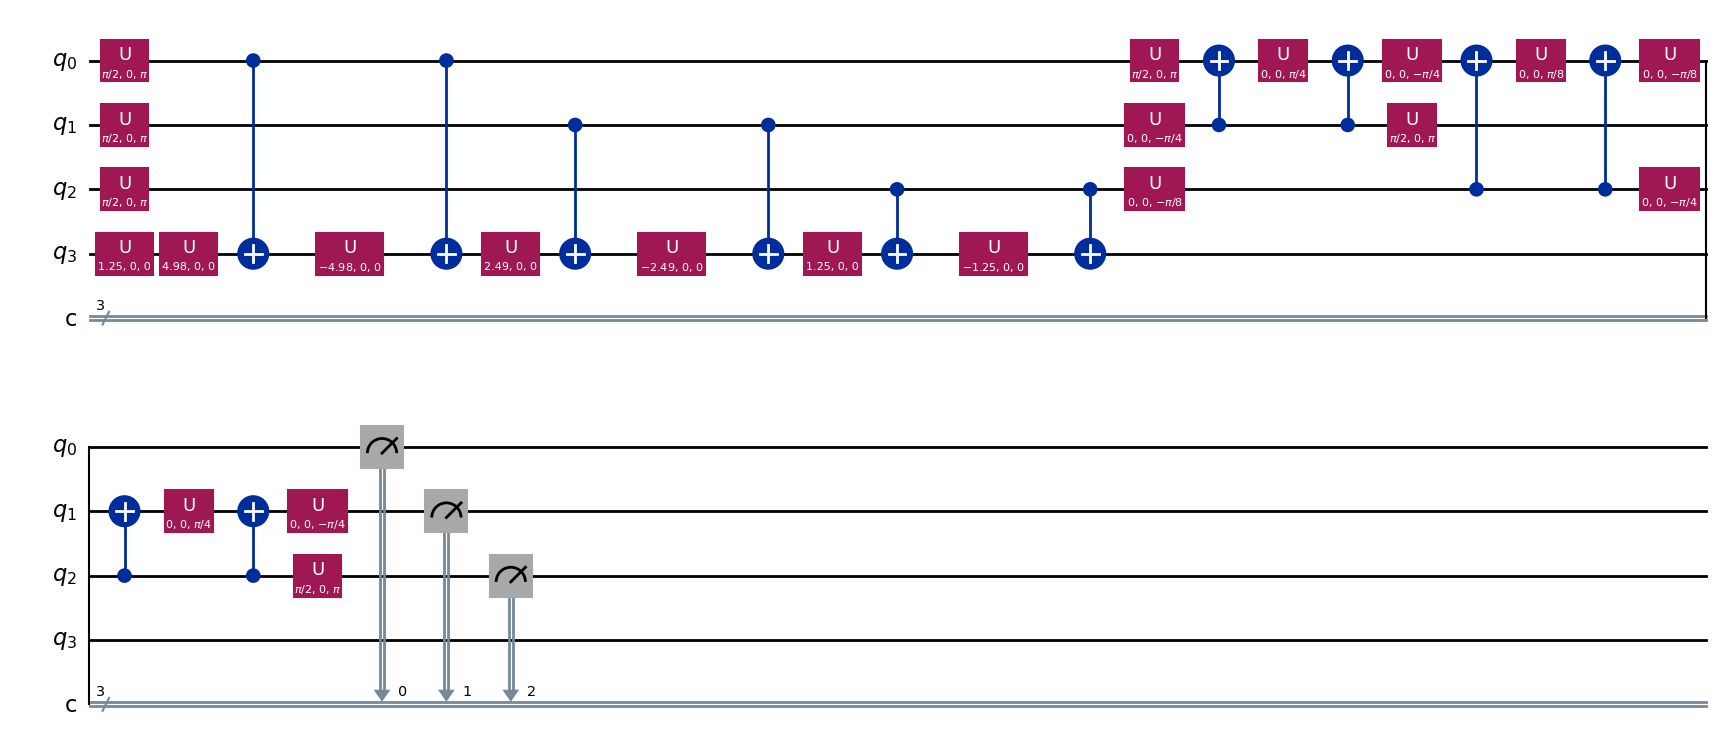

In [120]:
circuit.decompose(reps=8).draw(output='mpl', style="iqp", plot_barriers=False)

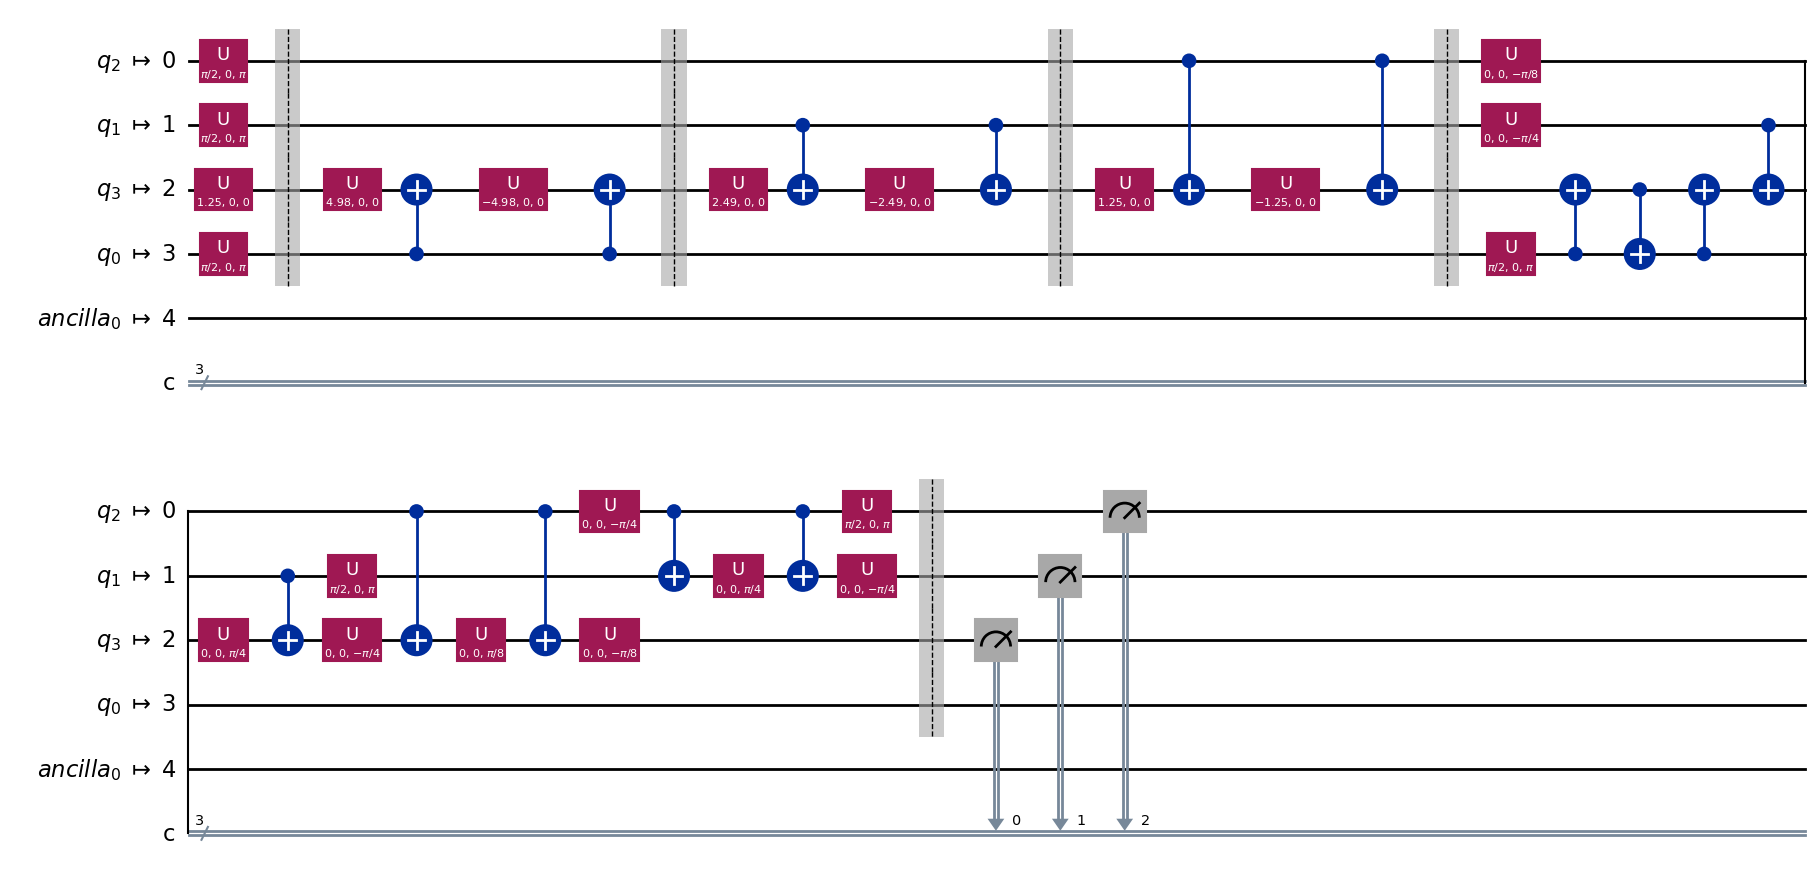

In [121]:
transpile(circuit,basis_gates=['u','cx'] , backend=backend).draw(output='mpl', style="iqp", plot_barriers=True)